# Вариант 1: Vanilla CatBoost

CatBoost "из коробки" умеет работать не только с категориальными признаками, но и текстовыми, поэтому его можно попробовать как одно из базовых решений. CatBoost использует собственный метод векторизации текстовых данных, который отличается от традиционных подходов, таких как TF-IDF или Word2Vec. 

In [1]:
# !pip install catboost

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error, f1_score

from catboost import CatBoostClassifier, Pool, metrics

## Общий код

In [3]:
def split_data_cls(X, y, random_state=42):
    """Разделение данных на трейн, валидацию и сплит"""
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=random_state)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2, random_state=random_state)

    return X_train, X_val, X_test, y_train, y_val, y_test

Размеченные данные, которые сохранили после EDA:

In [4]:
df = pd.read_csv('data.csv') # размеченные данные

In [5]:
df.head(3)

,id,answer1,score1,answer2,score2,answer3,score3,result
0,train_0,для анализа массивов данных необходимых в работе,2.0,для анализа массивов данных необходимых в работе,2.0,"стараюсь всегда брать задачи, выполнение котор...",2.0,6.0
1,train_1,Буду использовать полученные знания в работе д...,2.0,Автоматизирую процесс сбора данных и дальнейше...,2.0,Задача по анализу кода и содержанию пакетов - ...,1.5,5.5
2,train_2,хочу стать топовым программистом во всём мире ...,1.5,изучаю программирование,1.5,-,0.0,3.0


## 1.1. Задача классификации

Поставим задачу как задачу классификации ответов людей на положительные - 1 и отрицательные - 0. Считать ответ положительным будем по некоторому порогу. Попробуем подход с несколькими моделями (для каждого ответа по модели) и одной моделью, которая работает с общим ответом человека (конкатенация всех его ответов).

In [6]:
def conf_matrix(y, y_pred):
    """Вывод матрицы ошибок"""
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(3, 2))
    sns.heatmap(cm, annot=True, fmt='d', cmap='BuPu', xticklabels=['Класс 0', 'Класс 1'], yticklabels=['Класс 0', 'Класс 1'])
    plt.ylabel('Истиный класс')
    plt.xlabel('Предсказанный класс')
    plt.title('Матрица ошибок')
    plt.show()

In [7]:
def get_best_threshold(model, X_train, y_train):
    """Поиск лучшего порога отсечения, который максимизирует метрику f1_macro"""
    y_probs = model.predict_proba(X_train)[:, 1]

    thresholds = np.arange(0.0, 1.0, 0.01)
    f1_scores = []
    
    for threshold in thresholds:
        y_pred = (y_probs >= threshold).astype(int)
        f1 = f1_score(y_train, y_pred, average='macro')
        f1_scores.append(f1)
    
    optimal_threshold = thresholds[np.argmax(f1_scores)]
    optimal_f1 = max(f1_scores)
    return optimal_threshold

### 1.1.1. Пробная модель только для первого текстового ответа

Попробуем обучить модель для первого ответа и посмотрим насколько хорошо она справляется с задачей. Будем использовать задачу классификации (оценка за ответ больше 1.5 или нет) и регрессии (вещественная оценка от 0 до 3).

In [8]:
df.head(3)

,id,answer1,score1,answer2,score2,answer3,score3,result
0,train_0,для анализа массивов данных необходимых в работе,2.0,для анализа массивов данных необходимых в работе,2.0,"стараюсь всегда брать задачи, выполнение котор...",2.0,6.0
1,train_1,Буду использовать полученные знания в работе д...,2.0,Автоматизирую процесс сбора данных и дальнейше...,2.0,Задача по анализу кода и содержанию пакетов - ...,1.5,5.5
2,train_2,хочу стать топовым программистом во всём мире ...,1.5,изучаю программирование,1.5,-,0.0,3.0


In [9]:
X, y = df[['answer1']].copy(), df['score1'].copy()
y = (y > 1.5).astype(int)

X_train, X_val, X_test, y_train, y_val, y_test = split_data_cls(X, y)

In [10]:
train_pool = Pool(data=X_train, label=y_train, text_features=['answer1'])
val_pool = Pool(data=X_val, label=y_val, text_features=['answer1'])
test_pool = Pool(data=X_test, label=y_test, text_features=['answer1'])

In [11]:
model = CatBoostClassifier(iterations=1000, depth=6, learning_rate=0.01, verbose=0, custom_metric=[metrics.F1()], train_dir='baseline_model')
model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=50, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [12]:
y_train_pred = model.predict(train_pool)
y_val_pred = model.predict(val_pool)
y_test_pred = model.predict(test_pool)

Допустим, что нам одинаково важно верно классифицировать как положительные оценки, так и отрицаительные - тогда можно смотреть на метрику F1_macro:

In [13]:
print(classification_report(y_train, y_train_pred)) # трейн
print(classification_report(y_test, y_test_pred)) # тест

              precision    recall  f1-score   support

           0       0.83      0.99      0.90       229
           1       0.98      0.65      0.78       135

    accuracy                           0.87       364
   macro avg       0.90      0.82      0.84       364
weighted avg       0.88      0.87      0.86       364

              precision    recall  f1-score   support

           0       0.72      0.89      0.80       123
           1       0.70      0.42      0.53        73

    accuracy                           0.72       196
   macro avg       0.71      0.66      0.66       196
weighted avg       0.72      0.72      0.70       196



Можно подобрать оптимальный порог отсчечения классов, который максимизирует f1_macro на тесте:

In [14]:
optimal_threshold = get_best_threshold(model, X_test, y_test)
y_test_pred = (model.predict_proba(test_pool)[:, 1] >= optimal_threshold).astype(int)

In [15]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.81      0.78      0.80       123
           1       0.65      0.70      0.68        73

    accuracy                           0.75       196
   macro avg       0.73      0.74      0.74       196
weighted avg       0.75      0.75      0.75       196



За счет подходящего порога удалось неплохо выиграть в качестве по f1_macro. 

Также посмотрим ошибку такой модели, если брать вероятность положительного класса и умножать на 3 (переводить в вещественную оценку). Также сравним ошибку с лучшей константной моделью:

In [16]:
y_test_cont = df['score1'][y_test.index]
y_test_cont.head()

635    1.0
266    2.0
554    3.0
284    2.5
330    3.0
Name: score1, dtype: float64

In [17]:
mean_absolute_error(y_test_cont, model.predict_proba(test_pool)[:, 1] * 3)

0.5892561837848674

In [18]:
mean_absolute_error(y_test_cont, [np.median(y_train_pred)] * y_test.shape[0]) # константная модель

1.4502551020408163

In [19]:
# сравнение реальных оценок и предсказанных
pd.DataFrame({
    'real': y_test,
    'pred': model.predict_proba(X_test)[:, 1] * 3
}).head()

,real,pred
635,0,0.611937
266,1,1.202559
554,1,1.768215
284,1,0.800480
330,1,1.835243


Модель почти в 3 раза выигрывает у константной модели.

Попробуем добавить еще один признак - длину ответа. Предварительный разведывательный анализ показал, что это может быть информативный признак для классификатора:

In [20]:
answer_lens = X['answer1'].map(len)
X['answer_len'] = answer_lens

In [21]:
X.head(3)

,answer1,answer_len
0,для анализа массивов данных необходимых в работе,48
1,Буду использовать полученные знания в работе д...,139
2,хочу стать топовым программистом во всём мире ...,63


In [22]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data_cls(X, y)

train_pool = Pool(data=X_train, label=y_train, text_features=['answer1'])
val_pool = Pool(data=X_val, label=y_val, text_features=['answer1'])
test_pool = Pool(data=X_test, label=y_test, text_features=['answer1'])

In [23]:
model = CatBoostClassifier(iterations=1000, depth=6, learning_rate=0.01, verbose=0, custom_metric=[metrics.F1()], train_dir='baseline_model')
model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=50)

In [24]:
y_train_pred = model.predict(train_pool)
y_val_pred = model.predict(val_pool)
y_test_pred = model.predict(test_pool)

In [25]:
optimal_threshold = get_best_threshold(model, X_test, y_test)
y_test_pred = (model.predict_proba(test_pool)[:, 1] >= optimal_threshold).astype(int)

In [26]:
print(classification_report(y_train, y_train_pred)) # трейн
print(classification_report(y_test, y_test_pred)) # тест

              precision    recall  f1-score   support

           0       0.84      0.98      0.91       229
           1       0.96      0.68      0.80       135

    accuracy                           0.87       364
   macro avg       0.90      0.83      0.85       364
weighted avg       0.88      0.87      0.87       364

              precision    recall  f1-score   support

           0       0.79      0.84      0.81       123
           1       0.70      0.63      0.66        73

    accuracy                           0.76       196
   macro avg       0.74      0.73      0.74       196
weighted avg       0.76      0.76      0.76       196



Особо прироста в качестве нет, но и хуже от этого признака не стало. Оставим его.

Теперь попробуем подобрать более подходящие гиперпараметры для бустинга с помощью Optuna. Уже будем использовать также валидационное множество:

In [27]:
df.head()

,id,answer1,score1,answer2,score2,answer3,score3,result
0,train_0,для анализа массивов данных необходимых в работе,2.0,для анализа массивов данных необходимых в работе,2.0,"стараюсь всегда брать задачи, выполнение котор...",2.0,6.0
1,train_1,Буду использовать полученные знания в работе д...,2.0,Автоматизирую процесс сбора данных и дальнейше...,2.0,Задача по анализу кода и содержанию пакетов - ...,1.5,5.5
2,train_2,хочу стать топовым программистом во всём мире ...,1.5,изучаю программирование,1.5,-,0.0,3.0
3,train_3,"Смогу применить знания в своей професси, получ...",2.0,Буду заниматься автоматизацией и отладкой рабо...,2.5,Как и указано выше мне интересно улучшить суще...,2.5,7.0
4,train_4,Повысить уровень образования.,1.0,Использовать для автоматизации своих задач.,2.0,Не возникало рабочих сверхзадач связанных с на...,1.0,4.0


In [28]:
y.value_counts() # присутствует дисбаланс классов

score1
0    409
1    242
Name: count, dtype: int64

In [29]:
import optuna
import logging

optuna.logging.set_verbosity(optuna.logging.ERROR)

In [30]:
import optuna

def objective(trial): 
    model = CatBoostClassifier(
        iterations=trial.suggest_int('iterations', 300, 1000),
        learning_rate=trial.suggest_float('learning_rate', 1e-4, 0.1),
        depth=trial.suggest_int('depth', 2, 10),
        l2_leaf_reg=trial.suggest_float('l2_leaf_reg', 1e-4, 10, log=True),
        bagging_temperature=trial.suggest_float('bagging_temperature', 0, 2),
        eval_metric='Logloss',
        verbose=0
    )
    
    # Обучение модели и оценка на валидационном наборе
    model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=30)
    
    # Оценка качества модели
    y_pred = model.predict(val_pool)
    score = f1_score(y_val, y_pred, average='macro')

    # Вывод логов
    print(f'Trial {trial.number+1}: score = {score}')
    
    return score

sampler = optuna.samplers.RandomSampler(seed=42)
study = optuna.create_study(sampler=sampler, direction='maximize')
study.optimize(objective, n_trials=10)

Trial 1: score = 0.6196447230929989
Trial 2: score = 0.6270491803278688
Trial 3: score = 0.5951056729699666
Trial 4: score = 0.6457174638487209
Trial 5: score = 0.5873015873015873
Trial 6: score = 0.676775956284153
Trial 7: score = 0.6270491803278688
Trial 8: score = 0.6112718754306187
Trial 9: score = 0.6457174638487209
Trial 10: score = 0.6086021505376344


In [31]:
study.best_params

{'iterations': 850,
 'learning_rate': 0.020047410837620138,
 'depth': 6,
 'l2_leaf_reg': 0.09163741808778776,
 'bagging_temperature': 0.09290082543999545}

In [32]:
best_model = CatBoostClassifier(**study.best_params, eval_metric='Logloss', custom_metric=[metrics.F1()], train_dir='hypersearch_model')
best_model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=50)

y_train_pred = best_model.predict(train_pool)
y_val_pred = best_model.predict(val_pool)
y_test_pred = best_model.predict(test_pool)

0:	learn: 0.6864532	test: 0.6883844	best: 0.6883844 (0)	total: 20.4ms	remaining: 17.3s
1:	learn: 0.6793706	test: 0.6826220	best: 0.6826220 (1)	total: 42.6ms	remaining: 18s
2:	learn: 0.6725243	test: 0.6803006	best: 0.6803006 (2)	total: 65.3ms	remaining: 18.4s
3:	learn: 0.6663783	test: 0.6757691	best: 0.6757691 (3)	total: 86.8ms	remaining: 18.4s
4:	learn: 0.6610571	test: 0.6711085	best: 0.6711085 (4)	total: 112ms	remaining: 18.9s
5:	learn: 0.6549127	test: 0.6664549	best: 0.6664549 (5)	total: 134ms	remaining: 18.9s
6:	learn: 0.6495321	test: 0.6626418	best: 0.6626418 (6)	total: 159ms	remaining: 19.2s
7:	learn: 0.6437278	test: 0.6566245	best: 0.6566245 (7)	total: 182ms	remaining: 19.2s
8:	learn: 0.6392234	test: 0.6531522	best: 0.6531522 (8)	total: 206ms	remaining: 19.3s
9:	learn: 0.6342815	test: 0.6497657	best: 0.6497657 (9)	total: 232ms	remaining: 19.5s
10:	learn: 0.6282723	test: 0.6465872	best: 0.6465872 (10)	total: 258ms	remaining: 19.7s
11:	learn: 0.6252801	test: 0.6438487	best: 0.64384

In [33]:
# визуализация бейзлайн модели в сравнении с моделью, для которой подбирались гиперпараметры
# from catboost import MetricVisualizer
# visualizer = MetricVisualizer(['baseline_model', 'best_model'])
# visualizer.start()

              precision    recall  f1-score   support

           0       0.86      0.99      0.92       229
           1       0.98      0.73      0.83       135

    accuracy                           0.89       364
   macro avg       0.92      0.86      0.88       364
weighted avg       0.90      0.89      0.89       364

              precision    recall  f1-score   support

           0       0.79      0.85      0.82       123
           1       0.71      0.63      0.67        73

    accuracy                           0.77       196
   macro avg       0.75      0.74      0.74       196
weighted avg       0.76      0.77      0.76       196



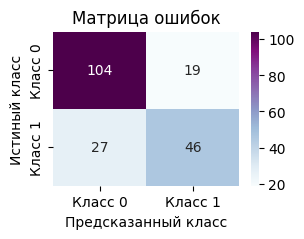

In [34]:
print(classification_report(y_train, y_train_pred))
print(classification_report(y_test, y_test_pred))
conf_matrix(y_test, y_test_pred)

Также подберем оптимальный порог:

In [35]:
optimal_threshold = get_best_threshold(best_model, X_test, y_test)
optimal_threshold

0.49

In [36]:
y_test_pred = (best_model.predict_proba(test_pool)[:, 1] >= optimal_threshold).astype(int)

              precision    recall  f1-score   support

           0       0.80      0.85      0.82       123
           1       0.71      0.64      0.68        73

    accuracy                           0.77       196
   macro avg       0.76      0.74      0.75       196
weighted avg       0.77      0.77      0.77       196



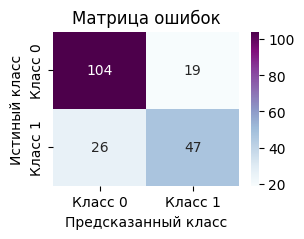

In [37]:
print(classification_report(y_test, y_test_pred))
conf_matrix(y_test, y_test_pred)

Переведем уверенности классифкатора в оценки:

In [38]:
y_test_cont = df['score1'][y_test.index]
mean_absolute_error(y_test_cont, best_model.predict_proba(test_pool)[:, 1] * 3)

0.5706364313274498

Вещественные оценки получаются чуть лучше, чем у baseline-модели.

## 1.2. По модели на каждый ответ

Будем решать задачу классификации для каждого ответа по отдельности, то есть для каждого ответа будет отдельный CatBoost-классификатор, который будет обучаться только на конкретном ответе.

Необходимо также продумать масштабируемое решение для произвольного числа ответов.

In [39]:
N = 3 # число моделей

In [40]:
df = pd.read_csv('data.csv')

In [41]:
df.head(3)

,id,answer1,score1,answer2,score2,answer3,score3,result
0,train_0,для анализа массивов данных необходимых в работе,2.0,для анализа массивов данных необходимых в работе,2.0,"стараюсь всегда брать задачи, выполнение котор...",2.0,6.0
1,train_1,Буду использовать полученные знания в работе д...,2.0,Автоматизирую процесс сбора данных и дальнейше...,2.0,Задача по анализу кода и содержанию пакетов - ...,1.5,5.5
2,train_2,хочу стать топовым программистом во всём мире ...,1.5,изучаю программирование,1.5,-,0.0,3.0


In [42]:
df.drop(columns=['id', 'result'], inplace=True)

In [43]:
df.isna().sum()

answer1    0
score1     0
answer2    1
score2     0
answer3    0
score3     0
dtype: int64

In [44]:
df = df.fillna('')

In [45]:
df.isna().sum()

answer1    0
score1     0
answer2    0
score2     0
answer3    0
score3     0
dtype: int64

Добавляем признаки - длины ответов:

In [46]:
for i in range(N):
    df[f'answer{i+1}_len'] = df[f'answer{i+1}'].map(len)

In [47]:
df.head(3)

,answer1,score1,answer2,score2,answer3,score3,answer1_len,answer2_len,answer3_len
0,для анализа массивов данных необходимых в работе,2.0,для анализа массивов данных необходимых в работе,2.0,"стараюсь всегда брать задачи, выполнение котор...",2.0,48,48,548
1,Буду использовать полученные знания в работе д...,2.0,Автоматизирую процесс сбора данных и дальнейше...,2.0,Задача по анализу кода и содержанию пакетов - ...,1.5,139,113,320
2,хочу стать топовым программистом во всём мире ...,1.5,изучаю программирование,1.5,-,0.0,63,23,1


In [48]:
X_df, y_df = df.drop(columns=['score1', 'score2', 'score3']), df[['score1', 'score2', 'score3']]

In [49]:
X_df.head(3)

,answer1,answer2,answer3,answer1_len,answer2_len,answer3_len
0,для анализа массивов данных необходимых в работе,для анализа массивов данных необходимых в работе,"стараюсь всегда брать задачи, выполнение котор...",48,48,548
1,Буду использовать полученные знания в работе д...,Автоматизирую процесс сбора данных и дальнейше...,Задача по анализу кода и содержанию пакетов - ...,139,113,320
2,хочу стать топовым программистом во всём мире ...,изучаю программирование,-,63,23,1


In [50]:
y_df.head(3)

,score1,score2,score3
0,2.0,2.0,2.0
1,2.0,2.0,1.5
2,1.5,1.5,0.0


Разобьем также на трейн, валидацию и тест:

In [51]:
y_df = (y_df > 1.5).astype(int)

In [52]:
X_train_df, X_val_df, X_test_df, y_train_df, y_val_df, y_test_df = split_data_cls(X_df, y_df)

С гиперпараметрами для подбора определились - тут будем также использовать их:

In [53]:
def train_model(train_pool, val_pool, test_pool, y_test_cont):
    """Обучение модели для предсказания оценки для ответа на котнкретный вопрос"""
    def objective(trial): 
        model = CatBoostClassifier(
            iterations=trial.suggest_int('iterations', 300, 1000),
            learning_rate=trial.suggest_float('learning_rate', 1e-4, 0.1),
            depth=trial.suggest_int('depth', 2, 10),
            l2_leaf_reg=trial.suggest_float('l2_leaf_reg', 1e-4, 100, log=True),
            bagging_temperature=trial.suggest_float('bagging_temperature', 0, 2),
            eval_metric='Logloss',
            verbose=0
        )
        
        # Обучение модели и оценка на валидационном наборе
        model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=50)
        
        # Оценка качества модели
        y_pred = model.predict(val_pool)
        return f1_score(y_val, y_pred, average='macro')
    
    sampler = optuna.samplers.RandomSampler(seed=42)
    study = optuna.create_study(sampler=sampler, direction='maximize')
    study.optimize(objective, n_trials=10)

    # Обучение модели с лучшими гиперпараметрами
    best_model = CatBoostClassifier(**study.best_params, eval_metric='Logloss', verbose=0)
    best_model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=30)
    
    y_test_pred = best_model.predict(test_pool)

    # Выбираем оптимальный порог отсечения
    optimal_threshold = get_best_threshold(best_model, test_pool, test_pool.get_label())
    y_test_pred = (best_model.predict_proba(test_pool)[:, 1] >= optimal_threshold).astype(int)

    # Выводим метрики
    print(f'Answer {i+1}:')
    print(classification_report(test_pool.get_label(), y_test_pred))
    conf_matrix(test_pool.get_label(), y_test_pred)

    mae_score = mean_absolute_error(y_test_cont, best_model.predict_proba(test_pool)[:, 1] * 3)
    mae_const_score = mean_absolute_error(y_test_cont, [np.median(train_pool.get_label())] * test_pool.shape[0]) # константная модель
    print(f'MAE = {mae_score}, MAE (best const model) = {mae_const_score}\n')

    return y_test_pred

Answer 1:
              precision    recall  f1-score   support

           0       0.87      0.55      0.68       123
           1       0.53      0.86      0.66        73

    accuracy                           0.67       196
   macro avg       0.70      0.71      0.67       196
weighted avg       0.75      0.67      0.67       196



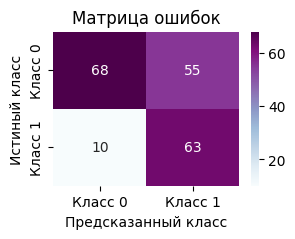

MAE = 0.6115154043552203, MAE (best const model) = 1.3903061224489797

Answer 2:
              precision    recall  f1-score   support

           0       0.77      0.67      0.72        87
           1       0.76      0.84      0.80       109

    accuracy                           0.77       196
   macro avg       0.77      0.76      0.76       196
weighted avg       0.77      0.77      0.76       196



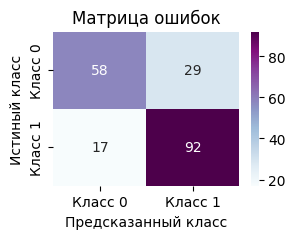

MAE = 0.5437829317912205, MAE (best const model) = 0.8239795918367347

Answer 3:
              precision    recall  f1-score   support

           0       0.74      0.80      0.77        84
           1       0.84      0.79      0.82       112

    accuracy                           0.80       196
   macro avg       0.79      0.80      0.79       196
weighted avg       0.80      0.80      0.80       196



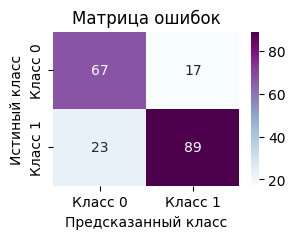

MAE = 0.6319057214327897, MAE (best const model) = 0.9158163265306123



In [54]:
predictions = pd.DataFrame() # датафрейм с предсказаниями для ответов в каждой колонке

for i in range(N):
    cols = [f'answer{i+1}', f'answer{i+1}_len']
    X_train, X_val, X_test = X_train_df[cols], X_val_df[cols], X_test_df[cols]
    y_train, y_val, y_test = y_train_df[f'score{i+1}'], y_val_df[f'score{i+1}'], y_test_df[f'score{i+1}']

    train_pool = Pool(data=X_train, label=y_train, text_features=[f'answer{i+1}'])
    val_pool = Pool(data=X_val, label=y_val, text_features=[f'answer{i+1}'])
    test_pool = Pool(data=X_test, label=y_test, text_features=[f'answer{i+1}'])

    # возвращаем непрерывные значения для сравнения по MAE
    y_test_cont = df.iloc[y_test_df.index][f'score{i+1}']

    y_pred = train_model(train_pool, val_pool, test_pool, y_test_cont)
    predictions[f'pred_score_{i+1}'] = y_pred

In [55]:
(0.67 + 0.76 + 0.79) / 3

0.7400000000000001

Видно, что задача классификации решается вполне неплохо - со средним `f1_macro` около 0.74. Учитывая, что данных довольно мало, можно сказать, что получились модели с хорошей точностью. А вот при переводе вероятности к регресионной оценке получаются не совсем точные результаты, в среднем чуть более полубалла погрешности на каждый вопрос. 

In [56]:
predictions.head()

,pred_score_1,pred_score_2,pred_score_3
0,0,0,0
1,1,0,0
2,0,1,0
3,0,0,0
4,0,0,0


## 1.3. Одна модель на все ответы

Можно попробовать объединить все ответы человека в один большой ответ и отдавать модели уже его. В таком случае можно свести задачу к построению одной модели бинарной классификации. Можно считать, что если человек набирает суммарно не меньше 6 баллов за 3 вопроса, то он успешно справляется с анкетированием.

In [57]:
df.head(3)

,answer1,score1,answer2,score2,answer3,score3,answer1_len,answer2_len,answer3_len
0,для анализа массивов данных необходимых в работе,2.0,для анализа массивов данных необходимых в работе,2.0,"стараюсь всегда брать задачи, выполнение котор...",2.0,48,48,548
1,Буду использовать полученные знания в работе д...,2.0,Автоматизирую процесс сбора данных и дальнейше...,2.0,Задача по анализу кода и содержанию пакетов - ...,1.5,139,113,320
2,хочу стать топовым программистом во всём мире ...,1.5,изучаю программирование,1.5,-,0.0,63,23,1


In [58]:
df['general_answer'] = df['answer1'] + ' ' + df['answer2'] + ' ' + df['answer3']
df['final_score'] = df['score1'] + df['score2'] + df['score3']

In [59]:
df = df[['general_answer', 'answer1_len', 'answer2_len', 'answer3_len', 'final_score']].copy()

Также можно попробовать добавить информацию о длине каждого из ответов по отдельности:

In [60]:
df.head(3)

,general_answer,answer1_len,answer2_len,answer3_len,final_score
0,для анализа массивов данных необходимых в рабо...,48,48,548,6.0
1,Буду использовать полученные знания в работе д...,139,113,320,5.5
2,хочу стать топовым программистом во всём мире ...,63,23,1,3.0


Также обучим CatBoost-классификатор:

In [61]:
X, y = df.drop(columns=['final_score']), df['final_score']
y = (y >= 6).astype(int)
X_train, X_val, X_test, y_train, y_val, y_test = split_data_cls(X, y)

train_pool = Pool(data=X_train, label=y_train, text_features=['general_answer'])
val_pool = Pool(data=X_val, label=y_val, text_features=['general_answer'])
test_pool = Pool(data=X_test, label=y_test, text_features=['general_answer'])

In [62]:
def objective(trial): 
    model = CatBoostClassifier(
        iterations=trial.suggest_int('iterations', 300, 1000),
        learning_rate=trial.suggest_float('learning_rate', 1e-4, 0.1),
        depth=trial.suggest_int('depth', 2, 10),
        l2_leaf_reg=trial.suggest_float('l2_leaf_reg', 1e-4, 10, log=True),
        bagging_temperature=trial.suggest_float('bagging_temperature', 0, 2),
        auto_class_weights='Balanced',
        eval_metric='Logloss',
        verbose=0
    )
    
    # Обучение модели и оценка на валидационном наборе
    model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=50)
    
    # Оценка качества модели
    y_pred = model.predict(val_pool)
    score = f1_score(y_val, y_pred, average='macro')

    # Вывод логов
    print(f'Trial {trial.number+1}: score = {score}')
    
    return score

In [63]:
sampler = optuna.samplers.RandomSampler(seed=42)
study = optuna.create_study(sampler=sampler, direction='maximize')
study.optimize(objective, n_trials=3)

Trial 1: score = 0.675
Trial 2: score = 0.7242424242424242
Trial 3: score = 0.6811161583387411


In [64]:
# Обучение модели с лучшими гиперпараметрами
best_model = CatBoostClassifier(**study.best_params, eval_metric='Logloss')
best_model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=50, plot=0, verbose=1)

y_train_pred = best_model.predict(train_pool)
y_test_pred = best_model.predict(test_pool)

0:	learn: 0.6905132	test: 0.6917944	best: 0.6917944 (0)	total: 547ms	remaining: 3m 43s
1:	learn: 0.6876730	test: 0.6900064	best: 0.6900064 (1)	total: 1.36s	remaining: 4m 37s
2:	learn: 0.6851535	test: 0.6888615	best: 0.6888615 (2)	total: 1.96s	remaining: 4m 24s
3:	learn: 0.6825948	test: 0.6870967	best: 0.6870967 (3)	total: 2.53s	remaining: 4m 16s
4:	learn: 0.6801728	test: 0.6854637	best: 0.6854637 (4)	total: 3.02s	remaining: 4m 4s
5:	learn: 0.6774225	test: 0.6836848	best: 0.6836848 (5)	total: 3.51s	remaining: 3m 55s
6:	learn: 0.6742912	test: 0.6827303	best: 0.6827303 (6)	total: 3.95s	remaining: 3m 46s
7:	learn: 0.6709811	test: 0.6803208	best: 0.6803208 (7)	total: 4.4s	remaining: 3m 40s
8:	learn: 0.6688027	test: 0.6788315	best: 0.6788315 (8)	total: 4.84s	remaining: 3m 35s
9:	learn: 0.6668399	test: 0.6771960	best: 0.6771960 (9)	total: 5.31s	remaining: 3m 31s
10:	learn: 0.6648183	test: 0.6765566	best: 0.6765566 (10)	total: 5.78s	remaining: 3m 29s
11:	learn: 0.6629454	test: 0.6752132	best: 

In [65]:
study.best_params

{'iterations': 409,
 'learning_rate': 0.005902552855603127,
 'depth': 9,
 'l2_leaf_reg': 0.10129197956845731,
 'bagging_temperature': 1.416145155592091}

              precision    recall  f1-score   support

           0       0.93      1.00      0.97       235
           1       1.00      0.87      0.93       129

    accuracy                           0.95       364
   macro avg       0.97      0.93      0.95       364
weighted avg       0.96      0.95      0.95       364



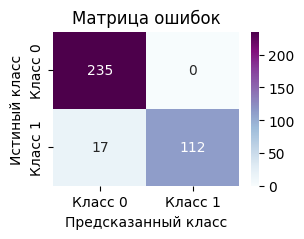

In [66]:
print(classification_report(y_train, y_train_pred))
conf_matrix(y_train, y_train_pred)

              precision    recall  f1-score   support

           0       0.73      0.90      0.81       126
           1       0.70      0.40      0.51        70

    accuracy                           0.72       196
   macro avg       0.72      0.65      0.66       196
weighted avg       0.72      0.72      0.70       196



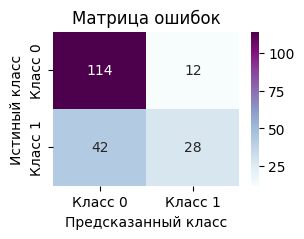

In [67]:
print(classification_report(y_test, y_test_pred))
conf_matrix(y_test, y_test_pred)

In [68]:
# Выбираем оптимальный порог отсечения
optimal_threshold = get_best_threshold(best_model, test_pool, test_pool.get_label())
y_test_pred = (best_model.predict_proba(test_pool)[:, 1] >= optimal_threshold).astype(int)

              precision    recall  f1-score   support

           0       0.77      0.84      0.80       126
           1       0.66      0.54      0.59        70

    accuracy                           0.73       196
   macro avg       0.71      0.69      0.70       196
weighted avg       0.73      0.73      0.73       196



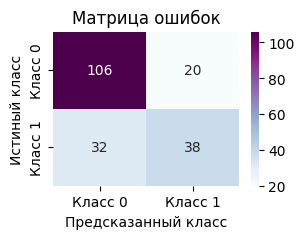

In [69]:
print(classification_report(y_test, y_test_pred))
conf_matrix(y_test, y_test_pred)

Длина ответа не помогает в предсказании. Модель довольно сильно переобучается и в целом показывает результат хуже, чем несколько отдельных моделей. Возможно, это связано с тем, что у каждого ответа немного своя специфика и когда мы их объединяем теряется интепретация для модели.

# * Задача регрессии

Можно попробовать предсказывать оценку от 0 до 3 сразу, то есть решать задачу регрессии. 

In [70]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

In [71]:
def reg_metrics(y, y_pred):
    """Выводит метрики регрессии"""
    mae = mean_absolute_error(y, y_pred)
    rmse = root_mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)

    print(f'MAE = {mae}, RMSE = {rmse}, R2 = {r2}')

### Пробная модель только для первого ответа

In [72]:
df = pd.read_csv('data.csv')
df = df.fillna('')

for i in range(N):
    df[f'answer{i+1}_len'] = df[f'answer{i+1}'].map(len)

In [73]:
df.head(3)

,id,answer1,score1,answer2,score2,answer3,score3,result,answer1_len,answer2_len,answer3_len
0,train_0,для анализа массивов данных необходимых в работе,2.0,для анализа массивов данных необходимых в работе,2.0,"стараюсь всегда брать задачи, выполнение котор...",2.0,6.0,48,48,548
1,train_1,Буду использовать полученные знания в работе д...,2.0,Автоматизирую процесс сбора данных и дальнейше...,2.0,Задача по анализу кода и содержанию пакетов - ...,1.5,5.5,139,113,320
2,train_2,хочу стать топовым программистом во всём мире ...,1.5,изучаю программирование,1.5,-,0.0,3.0,63,23,1


In [74]:
df['score1'].value_counts()

score1
1.00    294
2.00    159
3.00     70
0.00     57
1.50     45
0.50     13
2.50      8
2.25      5
Name: count, dtype: int64

Можно приравнять оценки 2.25 к 2.5, потому что их слишком мало:

In [75]:
df['score1'] = df['score1'].apply(lambda x: 2.5 if x == 2.25 else x)

In [76]:
X, y = df[['answer1']].copy(), df['score1'].copy()

In [77]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data_cls(X, y)

train_pool = Pool(data=X_train, label=y_train, text_features=['answer1'])
val_pool = Pool(data=X_val, label=y_val, text_features=['answer1'])
test_pool = Pool(data=X_test, label=y_test, text_features=['answer1'])

In [78]:
model = CatBoostRegressor(iterations=1000, depth=6, verbose=0)
model.fit(train_pool, early_stopping_rounds=50, eval_set=val_pool, plot=1)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [79]:
y_train_pred = model.predict(train_pool)
y_val_pred = model.predict(val_pool)
y_test_pred = model.predict(test_pool)

In [80]:
reg_metrics(y_train, y_train_pred)

MAE = 0.28674196991535855, RMSE = 0.37638300239734074, R2 = 0.7807321010277255


In [81]:
reg_metrics(y_test, y_test_pred)

MAE = 0.5407924071732512, RMSE = 0.6930671371486402, R2 = 0.2557546000577017


Бейзлайн есть. Попробуем добавить информацию о длине ответа:

In [82]:
X['answer1_len'] = X['answer1'].map(len)

In [83]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data_cls(X, y)

train_pool = Pool(data=X_train, label=y_train, text_features=['answer1'])
val_pool = Pool(data=X_val, label=y_val, text_features=['answer1'])
test_pool = Pool(data=X_test, label=y_test, text_features=['answer1'])

In [84]:
model = CatBoostRegressor(iterations=1000, depth=6, verbose=0)
model.fit(train_pool, early_stopping_rounds=50, eval_set=val_pool, plot=1)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [85]:
y_train_pred = model.predict(train_pool)
y_val_pred = model.predict(val_pool)
y_test_pred = model.predict(test_pool)

In [86]:
reg_metrics(y_train, y_train_pred)
reg_metrics(y_test, y_test_pred)

MAE = 0.2895099832322319, RMSE = 0.3646822432330722, R2 = 0.7941531214522269
MAE = 0.5350232972957837, RMSE = 0.6716261841265483, R2 = 0.301090756394782


Стало немного лучше. Оставим этот вариант и подберем гиперпараметры:

In [87]:
def objective(trial): 
    model = CatBoostRegressor(
        iterations=trial.suggest_int('iterations', 300, 2000),
        learning_rate=trial.suggest_float('learning_rate', 1e-4, 0.1),
        depth=trial.suggest_int('depth', 2, 12),
        l2_leaf_reg=trial.suggest_float('l2_leaf_reg', 1e-4, 10, log=True),
        verbose=0
    )
    
    # Обучение модели и оценка на валидационном наборе
    model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=100)
    
    # Оценка качества модели
    y_pred = model.predict(val_pool)
    score = root_mean_squared_error(y_val, y_pred)

    # Вывод логов
    print(f'Trial {trial.number+1}: score = {score}')
    
    return score

In [88]:
sampler = optuna.samplers.RandomSampler(seed=42)
study = optuna.create_study(sampler=sampler, direction='maximize')
study.optimize(objective, n_trials=10)

Trial 1: score = 0.6536552855471048
Trial 2: score = 0.6563265133351025
Trial 3: score = 0.6506221031111177
Trial 4: score = 0.6517271958208136
Trial 5: score = 0.6423650126098982
Trial 6: score = 0.642540201310617
Trial 7: score = 0.6344606438504701
Trial 8: score = 0.6550622007392662
Trial 9: score = 0.6579253551696101
Trial 10: score = 0.647544656533506


In [89]:
study.best_params

{'iterations': 410,
 'learning_rate': 0.094893665171608,
 'depth': 12,
 'l2_leaf_reg': 1.1015056790269626}

In [90]:
# Обучение модели с лучшими гиперпараметрами
best_model = CatBoostRegressor(**study.best_params, early_stopping_rounds=100)
best_model.fit(train_pool, eval_set=val_pool, plot=0, verbose=1)

y_train_pred = best_model.predict(train_pool)
y_test_pred = best_model.predict(test_pool)

0:	learn: 0.7835900	test: 0.7962676	best: 0.7962676 (0)	total: 1.64s	remaining: 11m 11s
1:	learn: 0.7649695	test: 0.7818785	best: 0.7818785 (1)	total: 3.16s	remaining: 10m 44s
2:	learn: 0.7471117	test: 0.7700878	best: 0.7700878 (2)	total: 4.4s	remaining: 9m 57s
3:	learn: 0.7325592	test: 0.7622115	best: 0.7622115 (3)	total: 5.67s	remaining: 9m 36s
4:	learn: 0.7195474	test: 0.7553302	best: 0.7553302 (4)	total: 6.96s	remaining: 9m 23s
5:	learn: 0.7052402	test: 0.7424586	best: 0.7424586 (5)	total: 8.49s	remaining: 9m 31s
6:	learn: 0.6949486	test: 0.7376304	best: 0.7376304 (6)	total: 10.1s	remaining: 9m 39s
7:	learn: 0.6819609	test: 0.7322438	best: 0.7322438 (7)	total: 11.3s	remaining: 9m 27s
8:	learn: 0.6733144	test: 0.7300566	best: 0.7300566 (8)	total: 12.5s	remaining: 9m 16s
9:	learn: 0.6651486	test: 0.7272643	best: 0.7272643 (9)	total: 13.9s	remaining: 9m 15s
10:	learn: 0.6536784	test: 0.7288494	best: 0.7272643 (9)	total: 15.3s	remaining: 9m 14s
11:	learn: 0.6476173	test: 0.7258616	best

In [91]:
reg_metrics(y_train, y_train_pred)
reg_metrics(y_test, y_test_pred)

MAE = 0.23776621245236373, RMSE = 0.3059576664682429, R2 = 0.8551102275219887
MAE = 0.5223154525152817, RMSE = 0.6620304456448246, R2 = 0.32091917036921536


Обучим 3 таких модели.

## По модели на каждый ответ

Пусть каждый регрессор предсказывает оценку для каждого из ответов по отдельности.

In [92]:
df.head(3)

,id,answer1,score1,answer2,score2,answer3,score3,result,answer1_len,answer2_len,answer3_len
0,train_0,для анализа массивов данных необходимых в работе,2.0,для анализа массивов данных необходимых в работе,2.0,"стараюсь всегда брать задачи, выполнение котор...",2.0,6.0,48,48,548
1,train_1,Буду использовать полученные знания в работе д...,2.0,Автоматизирую процесс сбора данных и дальнейше...,2.0,Задача по анализу кода и содержанию пакетов - ...,1.5,5.5,139,113,320
2,train_2,хочу стать топовым программистом во всём мире ...,1.5,изучаю программирование,1.5,-,0.0,3.0,63,23,1


In [93]:
df['answer1']

0       для анализа массивов данных необходимых в работе
1      Буду использовать полученные знания в работе д...
2      хочу стать топовым программистом во всём мире ...
3      Смогу применить знания в своей професси, получ...
4                          Повысить уровень образования.
                             ...                        
646               Хочу улучшить свои знания в этой сфере
647    Есть огромное желание, стремление, а главное т...
648       Хочу научиться основам программирования Python
649    При получении информации об обучении я не сраз...
650                               Хоче сменить профессию
Name: answer1, Length: 651, dtype: object

In [94]:
for i in range(N):
    df[f'answer{i+1}_len'] = df[f'answer{i+1}'].map(len)

In [95]:
X_df, y_df = df.drop(columns=['score1', 'score2', 'score3']), df[['score1', 'score2', 'score3']]

In [96]:
X_df.head(3)

,id,answer1,answer2,answer3,result,answer1_len,answer2_len,answer3_len
0,train_0,для анализа массивов данных необходимых в работе,для анализа массивов данных необходимых в работе,"стараюсь всегда брать задачи, выполнение котор...",6.0,48,48,548
1,train_1,Буду использовать полученные знания в работе д...,Автоматизирую процесс сбора данных и дальнейше...,Задача по анализу кода и содержанию пакетов - ...,5.5,139,113,320
2,train_2,хочу стать топовым программистом во всём мире ...,изучаю программирование,-,3.0,63,23,1


In [97]:
y_df.head(3)

,score1,score2,score3
0,2.0,2.0,2.0
1,2.0,2.0,1.5
2,1.5,1.5,0.0


Разобьем также на трейн, валидацию и тест:

In [98]:
# через функцию не получится из-за стратификации - поэтому придется продублировать код функции здесь
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_df, y_df, test_size=0.3, random_state=42)
X_train_df, X_val_df, y_train_df, y_val_df = train_test_split(X_train_df, y_train_df, test_size=0.2, random_state=42)

In [99]:
X_val.head()

,answer1,answer1_len
152,Необходимо постараться ускорить некоторвые про...,87
47,В школе и на первом курсе института очень увле...,255
285,Расширение кругозора. Попробовать новое. Найти...,267
233,"Получив новые знания и навыки, смогу в дальней...",323
260,Чтобы развиваться и применять полученные знани...,70


С гиперпараметрами для подбора определились - тут буддем также использовать их:

In [100]:
def train_model(train_pool, val_pool, test_pool):
    """Обучение модели для предсказания оценки для ответа на котнкретный вопрос"""
    def objective(trial): 
        model = CatBoostRegressor(
            iterations=trial.suggest_int('iterations', 300, 2000),
            learning_rate=trial.suggest_float('learning_rate', 1e-4, 0.1),
            depth=trial.suggest_int('depth', 2, 12),
            l2_leaf_reg=trial.suggest_float('l2_leaf_reg', 1e-4, 10, log=True),
            verbose=0
        )
            
        # Обучение модели и оценка на валидационном наборе
        model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=50)
        
        # Оценка качества модели
        y_pred = model.predict(val_pool)
        return root_mean_squared_error(y_val, y_pred)
    
    sampler = optuna.samplers.RandomSampler(seed=42)
    study = optuna.create_study(sampler=sampler, direction='maximize')
    study.optimize(objective, n_trials=10)

    # Обучение модели с лучшими гиперпараметрами
    best_model = CatBoostRegressor(**study.best_params, verbose=0)
    best_model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=50)

    # Делаем предсказание на тесте
    y_test_pred = best_model.predict(test_pool)

    # Выводим метрики
    rmse = root_mean_squared_error(test_pool.get_label(), y_test_pred)
    mae = mean_absolute_error(test_pool.get_label(), y_test_pred)
    r2 = r2_score(test_pool.get_label(), y_test_pred)

    print(f'Answer {i+1}:')
    print(f'RMSE = {rmse}, MAE = {mae}, R2 = {r2}\n')

    return y_test_pred

In [101]:
predictions = pd.DataFrame() # датафрейм с предсказаниями для ответов в каждой колонке

for i in range(N):
    cols = [f'answer{i+1}', f'answer{i+1}_len']
    X_train, X_val, X_test = X_train_df[cols], X_val_df[cols], X_test_df[cols]
    y_train, y_val, y_test = y_train_df[f'score{i+1}'], y_val_df[f'score{i+1}'], y_test_df[f'score{i+1}']

    train_pool = Pool(data=X_train, label=y_train, text_features=[f'answer{i+1}'])
    val_pool = Pool(data=X_val, label=y_val, text_features=[f'answer{i+1}'])
    test_pool = Pool(data=X_test, label=y_test, text_features=[f'answer{i+1}'])

    y_pred = train_model(train_pool, val_pool, test_pool)
    predictions[f'pred_score_{i+1}'] = y_pred

Answer 1:
RMSE = 0.627374450041709, MAE = 0.5055955306637174, R2 = 0.352580274848628

Answer 2:
RMSE = 0.7609011920638825, MAE = 0.6079554879499458, R2 = 0.25478337147959296

Answer 3:
RMSE = 0.7022152848682787, MAE = 0.5501065171163257, R2 = 0.44475857012861253



In [102]:
(0.51 + 0.61 + 0.55) / 3 # средняя ошибка RMSE

0.5566666666666668

## Одна модель на все ответы

Также можно попробовать добавить информацию о длине каждого из ответов по отдельности:

In [103]:
df.head(3)

,id,answer1,score1,answer2,score2,answer3,score3,result,answer1_len,answer2_len,answer3_len
0,train_0,для анализа массивов данных необходимых в работе,2.0,для анализа массивов данных необходимых в работе,2.0,"стараюсь всегда брать задачи, выполнение котор...",2.0,6.0,48,48,548
1,train_1,Буду использовать полученные знания в работе д...,2.0,Автоматизирую процесс сбора данных и дальнейше...,2.0,Задача по анализу кода и содержанию пакетов - ...,1.5,5.5,139,113,320
2,train_2,хочу стать топовым программистом во всём мире ...,1.5,изучаю программирование,1.5,-,0.0,3.0,63,23,1


Обучим CatBoost-регрессор:

In [116]:
df['general_answer'] = df['answer1'] + ' ' + df['answer2'] + ' ' + df['answer3'] 

In [117]:
X, y = df[['general_answer', 'answer1_len', 'answer2_len', 'answer3_len']], df['result']

# через функцию не получится из-за стратификации - поэтому придется продублировать код функции здесь
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [118]:
train_pool = Pool(data=X_train, label=y_train, text_features=['general_answer'])
val_pool = Pool(data=X_val, label=y_val, text_features=['general_answer'])
test_pool = Pool(data=X_test, label=y_test, text_features=['general_answer'])

In [120]:
def objective(trial): 
    model = CatBoostRegressor(
        iterations=trial.suggest_int('iterations', 300, 2000),
        learning_rate=trial.suggest_float('learning_rate', 1e-4, 0.1),
        depth=trial.suggest_int('depth', 2, 12),
        l2_leaf_reg=trial.suggest_float('l2_leaf_reg', 1e-4, 10, log=True),
        verbose=0
    )
        
    # Обучение модели и оценка на валидационном наборе
    model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=50)
    
    # Оценка качества модели
    y_pred = model.predict(val_pool)
    score = root_mean_squared_error(y_val, y_pred)

    # Вывод логов
    print(f'Train {trial.number}: score = {score}')

    return score

In [121]:
sampler = optuna.samplers.RandomSampler(seed=42)
study = optuna.create_study(sampler=sampler, direction='maximize')
study.optimize(objective, n_trials=5)

Train 0: score = 1.554480215013431
Train 1: score = 1.5390011447973615
Train 2: score = 1.549956710098929
Train 3: score = 1.5526909567612615
Train 4: score = 1.546330700377777


In [122]:
study.best_params

{'iterations': 937,
 'learning_rate': 0.09507635921035062,
 'depth': 10,
 'l2_leaf_reg': 0.09846738873614563}

In [123]:
# Обучение модели с лучшими гиперпараметрами
best_model = CatBoostRegressor(**study.best_params)
best_model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=50, plot=0, verbose=1)

y_train_pred = best_model.predict(train_pool)
y_test_pred = best_model.predict(test_pool)

0:	learn: 1.9965247	test: 1.9382371	best: 1.9382371 (0)	total: 1.2s	remaining: 18m 45s
1:	learn: 1.9215341	test: 1.8891772	best: 1.8891772 (1)	total: 2.51s	remaining: 19m 34s
2:	learn: 1.8625985	test: 1.8575150	best: 1.8575150 (2)	total: 3.44s	remaining: 17m 51s
3:	learn: 1.8128194	test: 1.8241276	best: 1.8241276 (3)	total: 4.42s	remaining: 17m 10s
4:	learn: 1.7625447	test: 1.7814418	best: 1.7814418 (4)	total: 5.36s	remaining: 16m 38s
5:	learn: 1.7286310	test: 1.7602735	best: 1.7602735 (5)	total: 6.3s	remaining: 16m 18s
6:	learn: 1.6919244	test: 1.7395677	best: 1.7395677 (6)	total: 7.23s	remaining: 16m
7:	learn: 1.6338399	test: 1.7168433	best: 1.7168433 (7)	total: 8.19s	remaining: 15m 50s
8:	learn: 1.5995526	test: 1.6924761	best: 1.6924761 (8)	total: 9.11s	remaining: 15m 39s
9:	learn: 1.5568964	test: 1.6717924	best: 1.6717924 (9)	total: 10s	remaining: 15m 29s
10:	learn: 1.5324226	test: 1.6614724	best: 1.6614724 (10)	total: 10.9s	remaining: 15m 20s
11:	learn: 1.5028546	test: 1.6479822	b

In [124]:
y_test_pred = best_model.predict(test_pool)

In [125]:
test_pool.get_label()

array([5.5, 8. , 3. , 5. , 2. , 4. , 5. , 3. , 6.5, 2. , 4. , 6. , 7. ,
       5.5, 5. , 6. , 6.5, 8. , 6. , 8. , 5. , 4. , 6. , 5. , 7. , 5. ,
       8. , 2. , 4. , 2. , 3. , 4.5, 4. , 5. , 5.5, 2. , 3.5, 5. , 8. ,
       3. , 3. , 5. , 4. , 2. , 5. , 3. , 6.5, 3. , 9. , 8. , 4. , 8. ,
       3. , 8. , 8. , 1. , 8. , 8.5, 3. , 5.5, 1. , 7. , 1. , 3. , 6. ,
       7. , 4.5, 8.5, 1. , 1.5, 7. , 6. , 3. , 8. , 2. , 5.5, 3. , 4.5,
       3. , 5. , 3. , 8. , 5. , 8. , 5. , 6. , 5. , 1. , 5. , 3.5, 3. ,
       4. , 8. , 2.5, 6. , 4. , 4. , 6. , 2. , 9. , 3. , 3. , 6. , 4. ,
       3. , 2. , 3. , 2.5, 7.5, 2. , 5. , 7. , 7. , 3.5, 4.5, 6. , 4.5,
       5. , 4. , 5. , 6. , 7. , 4. , 6. , 1. , 5. , 7. , 8. , 5. , 1. ,
       3. , 6. , 7. , 2. , 9. , 7. , 4. , 6. , 6. , 5. , 4.5, 8. , 4. ,
       2. , 7. , 6. , 0. , 4.5, 4. , 3. , 9. , 9. , 4. , 7. , 4. , 4.5,
       7. , 4. , 8. , 3. , 1. , 3.5, 4. , 6.5, 4. , 6. , 2. , 2. , 4.5,
       4. , 6. , 4.5, 9. , 3. , 6. , 3. , 5. , 2. , 8. , 3. , 2.

In [126]:
rmse = root_mean_squared_error(test_pool.get_label(), y_test_pred)
mae = mean_absolute_error(test_pool.get_label(), y_test_pred)
r2 = r2_score(test_pool.get_label(), y_test_pred)

print(f'RMSE = {rmse}, MAE = {mae}, R2 = {r2}\n')

RMSE = 1.6207537652441086, MAE = 1.2856377373558654, R2 = 0.4338502740158753



Тогда на каждую из моделей приходится примерно:

In [128]:
1.28 / 3

0.4266666666666667